## Train Segmentation or Keypoint YOLOv8 model

Notes:
- Shear, perspective, and rotation augmentations add error to bbox w/ keypoint dataset
- Mosaic and extreme scale might hide clues about usual pose of board games (pointing to center)


In [1]:
from ultralytics import YOLO
import cv2 
import matplotlib.pyplot as plt
 
# Load the model.
model = YOLO('yolov8n-seg.pt')

# Training.
results = model.train(
   data='../project-4-at-2023-09-02-19-51-b3ad348e/data.yaml',
   imgsz=640,
   epochs=120,
   batch=8,
   name='yolov8n_azul',
   single_cls=True,
   pretrained=False,
   translate=0.3,
   degrees=10,
   scale=0.2,
   perspective=0.0005,
   shear=5,
   fliplr=0.0,
   flipud=0.0,
   mixup=0.0,
   mosaic=0.0,
   copy_paste=0.1,
)

New https://pypi.org/project/ultralytics/8.0.169 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.109 🚀 Python-3.8.10 torch-1.13.0+cu117 CPU
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
yolo/engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=../project-4-at-2023-09-02-19-51-b3ad348e/data.yaml, epochs=120, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_azul, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, 

## Convert segmentation (polygon) dataset into keypoints
Assumptions:
- Keypoints are corners of board
- There are no occluded boards on dataset
- All boards are within image

In [63]:
import pandas as pd 
from glob import glob 
import numpy as np 
import matplotlib.pyplot as plt 
from ultralytics import YOLO

labelDir = '/home/garamizo/project-4-at-2023-09-02-19-51-b3ad348e_pose/valid/labels/*.txt'

for file in glob(labelDir):

    df = pd.read_csv(file, sep=' ', header=None)
    dfOut = pd.DataFrame(columns=['cls', 'x', 'y', 'width', 'height'] +
                        [f"p{a}{i+1}" for i in range(4) for a in ['x', 'y']])

    for i, row in df.iterrows():
        xy = np.reshape(row.to_numpy()[1:], [-1, 2])
        x1, y1, x2, y2 = np.nanmin(xy[:,0]), np.nanmin(xy[:,1]), np.nanmax(xy[:,0]), np.nanmax(xy[:,1])

        dist2 = np.sum((xy - 0.5)**2, axis=1)
        idxTop = np.argsort(dist2)[:2]
        idxBot = np.argsort(dist2)[2:]

        if signed_area(xy[idxTop[0]] - 0.5, xy[idxTop[1]] - 0.5) < 0:
            idx0, idx1 = idxTop[0], idxTop[1]
        else:
            idx0, idx1 = idxTop[1], idxTop[0]

        ptMea = (xy[idx0] + xy[idx1] + xy[idxBot[0]]) / 3
        dist0i = np.sum((xy[idx0] - ptMea)**2)
        dist1i = np.sum((xy[idx1] - ptMea)**2)
        if dist0i > dist1i:
            idx2, idx3 = idxBot[0], idxBot[1]
        else:
            idx2, idx3 = idxBot[1], idxBot[0]

        xy = xy[[idx0, idx1, idx2, idx3]]
        x, y, wid, hei = (x1 + x2)/2, (y1 + y2)/2, x2 - x1, y2 - y1
        dfOut.loc[i, :] = [0, x, y, wid, hei, *xy.reshape(-1).tolist()]

    dfOut.to_csv(file, sep=' ', header=None, index=None)

## Evaluate board tracking

Given an image, segment and rectify each board


0: 480x640 4 boards, 123.9ms
Speed: 2.8ms preprocess, 123.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


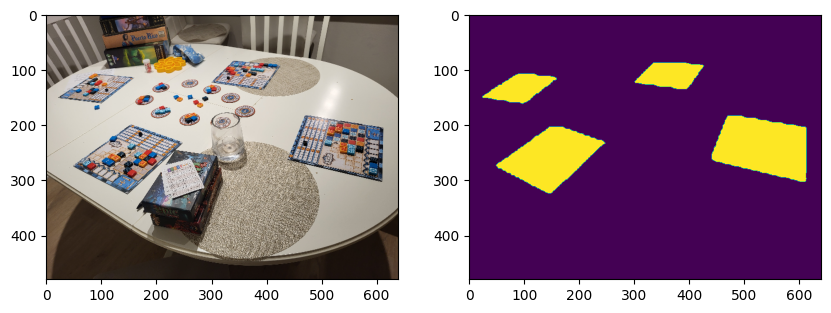

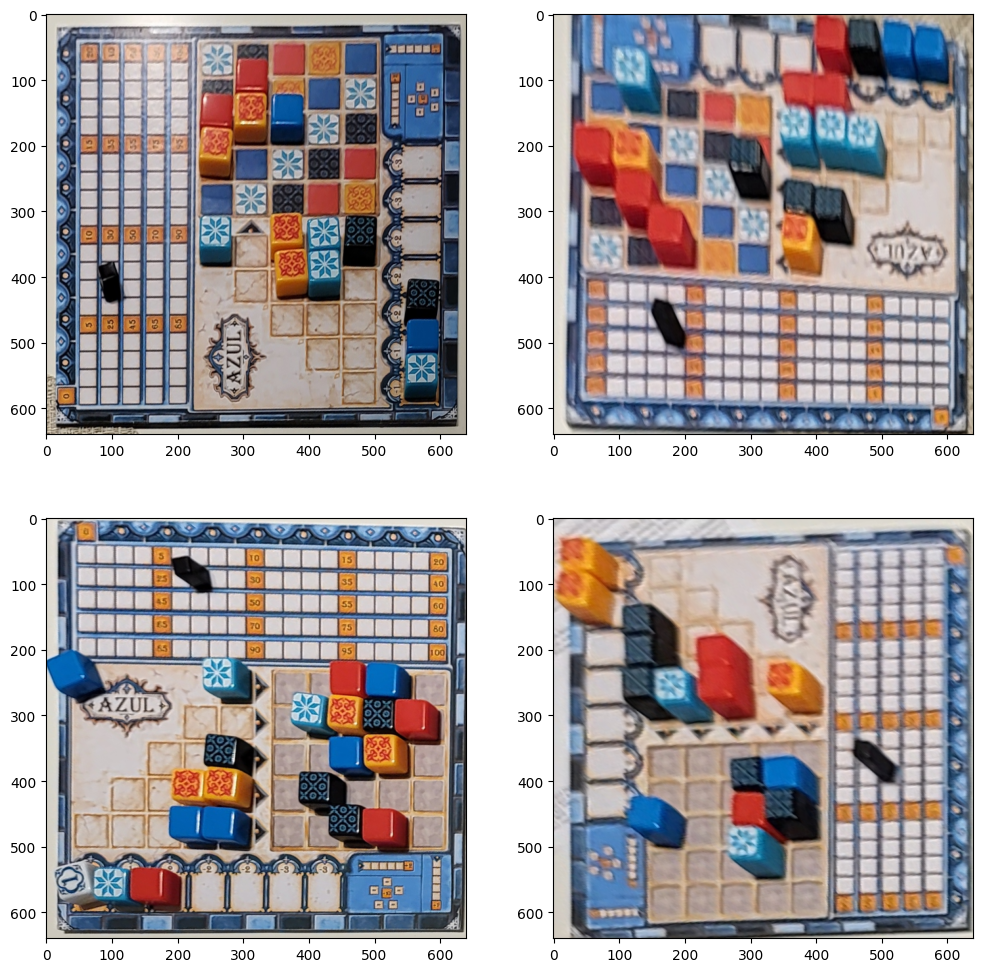

In [5]:
import azul.vision as vision 
import cv2 
import numpy as np
import matplotlib.pyplot as plt 

# img = cv2.imread('../Pictures/azul/20230831_184413.jpg')  # easy
# img = cv2.imread('../Pictures/azul/20230831_210022.jpg')  # feasible
img = cv2.imread('../Pictures/azul/20230831_184420.jpg')  # hard
# img = cv2.imread('../Pictures/azul/20230831_214908.jpg')  # vertical

masks = vision.segment(img)
maskMerge = np.sum(np.uint8(masks), axis=0)


h1, w1 = maskMerge.shape
hf, wf, _ = img.shape
BRD, FSZ = 10, 640
dst = np.float32([[BRD, BRD], [FSZ-BRD, BRD], [FSZ-BRD, FSZ-BRD], [BRD, FSZ-BRD]])
imgBoard = []

plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(cv2.cvtColor(cv2.resize(img, [640, 480]), cv2.COLOR_BGR2RGB));
plt.subplot(122), plt.imshow(maskMerge);

plt.figure(figsize=(12,12))
for i, data in enumerate(masks):
    mask = np.uint8(data)
    src = np.float32(vision.poly_corners(mask) * [wf/w1, hf/h1])
    matrix = cv2.getPerspectiveTransform(src, dst)
    frame = cv2.warpPerspective(img, matrix, (FSZ, FSZ))
    imgBoard.append(frame)

    plt.subplot(2,2,i+1), plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB));

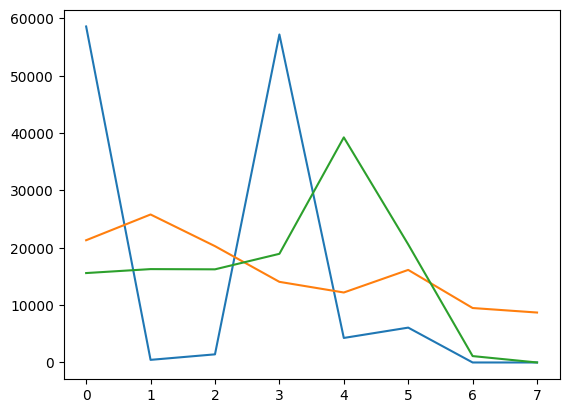

In [101]:
frame = cv2.cvtColor(imgBoard[0], cv2.COLOR_RGB2HSV)

masks = np.zeros((4,)+frame.shape[:-1], np.uint8)
masks[0,:200,:] = 255
masks[1,:,:200] = 255
masks[2,-200:,:] = 255
masks[3,:,-200:] = 255

i = 0
bins = 8
histB = cv2.calcHist([frame], [0], masks[i], [bins], [0, 256], False)
histG = cv2.calcHist([frame], [1], masks[i], [bins], [0, 256], False)
histR = cv2.calcHist([frame], [2], masks[i], [bins], [0, 256], False)

plt.plot(histB)
plt.plot(histG)
plt.plot(histR);